In [1]:
import gym
import torch
import torch.nn as nn
import numpy as np
from collections import deque
import random
from itertools import count
import torch.nn.functional as F
import matplotlib.pyplot as plt
import optuna

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [2]:
class duelling_dqn_model(nn.Module):

    def __init__(self, state_size, action_size, seed, fc1_units=64,  vl1_units = 256, al1_units = 256, type_num = 1):
        super(duelling_dqn_model, self).__init__()
        self.type_num = type_num

        self.fc1 = nn.Linear(state_size, fc1_units)
        self.value_layer_1 = nn.Linear(fc1_units, vl1_units)
        self.advantage_layer_1 = nn.Linear(fc1_units, al1_units)

        self.value_layer_2 = nn.Linear(vl1_units, 1)
        self.advantage_layer_2 = nn.Linear(al1_units, action_size)
    
    def forward(self, state):
        a=F.relu(self.fc1(state))
        adv=F.relu(self.advantage_layer_1(a))
        adv=self.advantage_layer_2(adv)
        value=F.relu(self.value_layer_1(a))
        value=self.value_layer_2(value) 
        advAverage = torch.mean(adv, dim=1, keepdim=True)
        Q = value + adv - advAverage
        return Q
    
    def select_action(self, state):
        with torch.no_grad():
            Q = self.forward(state)
            action_index = torch.argmax(Q, dim=1)
        return action_index.item()


In [3]:
class Memory(object):
    def __init__(self, memory_size: int) -> None:
        self.memory_size = memory_size
        self.buffer = deque(maxlen=self.memory_size)

    def add(self, experience) -> None:
        self.buffer.append(experience)

    def size(self):
        return len(self.buffer)

    def sample(self, batch_size: int, continuous: bool = True):
        if batch_size > len(self.buffer):
            batch_size = len(self.buffer)
        if continuous:
            rand = random.randint(0, len(self.buffer) - batch_size)
            return [self.buffer[i] for i in range(rand, rand + batch_size)]
        else:
            indexes = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
            return [self.buffer[i] for i in indexes]

    def clear(self):
        self.buffer.clear()


In [8]:
def objective(trial,env,type_num):
    # Define the search space
    params= {
      'batch_size' : trial.suggest_categorical('batch_size', [32,64,128]),
      'lr'  : trial.suggest_loguniform('lr',1e-5,1e-4),
      'eps_start' : trial.suggest_loguniform('eps_start',0.1,0.4),
      'replay_size':trial.suggest_categorical('replay_size', [50000,75000,100000]),
    }

    # Train the model with the given hyperparameters
    seed=1
    rewards_episode= duel_dqn(env,seed = seed,params = params,type_num = type_num)
    return np.mean(rewards_episode)

def duel_dqn(env,seed,params,type_num):
    print('\n')
    print("For seed =",seed)
    env = env
    env.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    qnetwork_local = duelling_dqn_model(state_shape, action_shape,seed,type_num=type_num).to(device)
    qnetwork_target = duelling_dqn_model(state_shape, action_shape,seed,type_num=type_num).to(device)
    # qnetwork_local = QNetwork().to(device)
    # qnetwork_target = QNetwork().to(device)
    qnetwork_target.load_state_dict(qnetwork_local.state_dict())
    optimizer = torch.optim.Adam(qnetwork_local.parameters(), lr=params['lr'])


    GAMMA = 0.99
    EXPLORE = 20000
    eps_start = params['eps_start']
    eps_end = 0.0001
    REPLAY_MEMORY = params['replay_size']
    BATCH = params['batch_size']
    max_episodes = 1000
    UPDATE_STEPS = 4

    memory_replay = Memory(REPLAY_MEMORY)

    epsilon = eps_start
    learn_steps = 0
    begin_learn = False
    scores_window = deque(maxlen=100)
    episode_rewards = []

    for epoch in range(max_episodes):
        state = env.reset()
        episode_reward = 0
        done = False
        while not done:
            prob = random.random()
            if prob < epsilon:
                action = random.choice(np.arange(action_shape))
            else:
                tensor_state = torch.FloatTensor(state).unsqueeze(0).to(device)
                action = qnetwork_local.select_action(tensor_state)
            next_state, reward, done, _ = env.step(action)
            episode_reward += reward

            memory_replay.add((state, next_state, action, reward, done))

            # Cheks if the replay buffer has enough samples to sample from
            if memory_replay.size() > 128:
                if not begin_learn:
                    begin_learn = True
                learn_steps += 1
                if learn_steps % UPDATE_STEPS == 0:
                    qnetwork_target.load_state_dict(qnetwork_local.state_dict())
                # Sampling batch size number of samples for target network
                batch = memory_replay.sample(BATCH, False)
                batch_state, batch_next_state, batch_action, batch_reward, batch_done = zip(*batch)

                batch_state = torch.FloatTensor(batch_state).to(device)
                batch_next_state = torch.FloatTensor(batch_next_state).to(device)
                batch_action = torch.FloatTensor(batch_action).unsqueeze(1).to(device)
                batch_reward = torch.FloatTensor(batch_reward).unsqueeze(1).to(device)
                batch_done = torch.FloatTensor(batch_done).unsqueeze(1).to(device)

                with torch.no_grad():
                    localQ_next = qnetwork_local(batch_next_state)
                    targetQ_next = qnetwork_target(batch_next_state)
                    local_max_action = torch.argmax(localQ_next, dim=1, keepdim=True)
                    y = batch_reward + (1 - batch_done) * GAMMA * targetQ_next.gather(1, local_max_action.long())

                loss = F.mse_loss(qnetwork_local(batch_state).gather(1, batch_action.long()), y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if epsilon > eps_end:
                    epsilon -= (eps_start - eps_end) / EXPLORE
            if done:
                break
            state = next_state
        scores_window.append(episode_reward)
        episode_rewards.append(episode_reward)
        print('\rEpisode {}\tMoving Average Score: {:.2f}'.format(epoch, np.mean(scores_window)), end="")
        if epoch % 100 == 0:
            print('\rEpisode {}\tMoving Average Score: {:.2f}'.format(epoch, np.mean(scores_window)))
        if np.mean(scores_window)>=env.spec.reward_threshold and epoch >= 100:
            print('\nEnvironment solved in {:d} episodes!\tAverageScore: {:.2f}'.format(epoch, np.mean(scores_window)))
            break

    return episode_rewards

In [9]:
env2 = gym.make('CartPole-v1')
state_shape = env2.observation_space.shape[0]
action_shape = env2.action_space.n

c:\Users\beher\anaconda3\lib\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\beher\anaconda3\lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [10]:
study = optuna.create_study(direction='maximize')

#Run the optimization
study.optimize(lambda trial: objective(trial, env2, 1), n_trials=5)

# Print the best parameters found
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-04-07 05:19:05,596] A new study created in memory with name: no-name-4c979209-ea4c-4cb3-b203-933b128b39fd
C:\Users\beher\AppData\Local\Temp\ipykernel_34124\2018789607.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lr'  : trial.suggest_loguniform('lr',1e-5,1e-4),
C:\Users\beher\AppData\Local\Temp\ipykernel_34124\2018789607.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eps_start' : trial.suggest_loguniform('eps_start',0.2,0.4),




For seed = 1
Episode 0	Moving Average Score: 17.00
Episode 100	Moving Average Score: 10.99
Episode 200	Moving Average Score: 10.98
Episode 300	Moving Average Score: 10.83
Episode 400	Moving Average Score: 11.64
Episode 500	Moving Average Score: 12.18
Episode 600	Moving Average Score: 15.22
Episode 700	Moving Average Score: 22.89
Episode 800	Moving Average Score: 49.71
Episode 900	Moving Average Score: 95.87
Episode 998	Moving Average Score: 96.73

[I 2024-04-07 05:24:32,732] Trial 0 finished with value: 33.641 and parameters: {'batch_size': 128, 'lr': 1.6567179623643446e-05, 'eps_start': 0.2847294497301925, 'replay_size': 100000}. Best is trial 0 with value: 33.641.


Episode 999	Moving Average Score: 96.59

For seed = 1
Episode 0	Moving Average Score: 10.00
Episode 100	Moving Average Score: 10.64
Episode 200	Moving Average Score: 13.59
Episode 300	Moving Average Score: 72.18
Episode 400	Moving Average Score: 321.96
Episode 500	Moving Average Score: 216.33
Episode 600	Moving Average Score: 185.16
Episode 700	Moving Average Score: 242.14
Episode 800	Moving Average Score: 313.55
Episode 900	Moving Average Score: 451.06
Episode 930	Moving Average Score: 473.76

[I 2024-04-07 05:53:15,965] Trial 1 finished with value: 212.00965665236052 and parameters: {'batch_size': 32, 'lr': 9.238223710785395e-05, 'eps_start': 0.2400134878145371, 'replay_size': 75000}. Best is trial 1 with value: 212.00965665236052.


Episode 931	Moving Average Score: 476.38
Environment solved in 931 episodes!	AverageScore: 476.38


For seed = 1
Episode 0	Moving Average Score: 10.00
Episode 100	Moving Average Score: 10.52
Episode 200	Moving Average Score: 10.44
Episode 300	Moving Average Score: 10.27
Episode 400	Moving Average Score: 10.90
Episode 500	Moving Average Score: 11.16
Episode 600	Moving Average Score: 13.14
Episode 700	Moving Average Score: 15.51
Episode 800	Moving Average Score: 12.41
Episode 900	Moving Average Score: 10.92
Episode 998	Moving Average Score: 22.16

[I 2024-04-07 05:54:39,924] Trial 2 finished with value: 12.766 and parameters: {'batch_size': 64, 'lr': 1.8772731204940125e-05, 'eps_start': 0.21148602735147412, 'replay_size': 50000}. Best is trial 1 with value: 212.00965665236052.


Episode 999	Moving Average Score: 22.40

For seed = 1
Episode 0	Moving Average Score: 17.00
Episode 100	Moving Average Score: 11.06
Episode 200	Moving Average Score: 80.97
Episode 300	Moving Average Score: 187.19
Episode 400	Moving Average Score: 184.39
Episode 500	Moving Average Score: 279.05
Episode 600	Moving Average Score: 319.90
Episode 700	Moving Average Score: 417.09
Episode 800	Moving Average Score: 447.03
Episode 817	Moving Average Score: 473.75

[I 2024-04-07 06:28:54,202] Trial 3 finished with value: 246.04761904761904 and parameters: {'batch_size': 128, 'lr': 9.64526166344084e-05, 'eps_start': 0.2748826230485416, 'replay_size': 75000}. Best is trial 3 with value: 246.04761904761904.


Episode 818	Moving Average Score: 476.45
Environment solved in 818 episodes!	AverageScore: 476.45


For seed = 1
Episode 0	Moving Average Score: 10.00
Episode 100	Moving Average Score: 10.25
Episode 200	Moving Average Score: 10.49
Episode 300	Moving Average Score: 10.16
Episode 400	Moving Average Score: 10.48
Episode 500	Moving Average Score: 10.57
Episode 600	Moving Average Score: 10.52
Episode 700	Moving Average Score: 10.58
Episode 800	Moving Average Score: 11.09
Episode 900	Moving Average Score: 11.87
Episode 998	Moving Average Score: 24.45

[I 2024-04-07 06:30:28,154] Trial 4 finished with value: 12.062 and parameters: {'batch_size': 128, 'lr': 1.0692552242663838e-05, 'eps_start': 0.20150835092092104, 'replay_size': 50000}. Best is trial 3 with value: 246.04761904761904.


Episode 999	Moving Average Score: 24.61Best trial:
  Value:  246.04761904761904
  Params: 
    batch_size: 128
    lr: 9.64526166344084e-05
    eps_start: 0.2748826230485416
    replay_size: 75000


In [11]:
num_seeds = 5
all_episode_rewards = []

for seed in range(num_seeds):
    episode_rewards = duel_dqn(env2,seed = seed,params = trial.params,type_num = 1)
    all_episode_rewards.append(episode_rewards)

# Calculate mean and variance across runs for each episode
max_length = max(len(v) for v in all_episode_rewards)
padded_rewards = [np.pad(v, (0, max_length - len(v)), mode='constant',constant_values = env2.spec.reward_threshold) for v in all_episode_rewards]
mean_rewards_cart_1 = np.mean(padded_rewards, axis=0)
variance_rewards_cart_1 = np.var(padded_rewards, axis=0)   



For seed = 0
Episode 0	Moving Average Score: 21.00
Episode 100	Moving Average Score: 18.69
Episode 200	Moving Average Score: 115.56
Episode 300	Moving Average Score: 465.41
Episode 305	Moving Average Score: 475.91
Environment solved in 305 episodes!	AverageScore: 475.91


For seed = 1
Episode 0	Moving Average Score: 17.00
Episode 100	Moving Average Score: 11.06
Episode 200	Moving Average Score: 80.97
Episode 300	Moving Average Score: 187.19
Episode 400	Moving Average Score: 184.39
Episode 500	Moving Average Score: 279.05
Episode 600	Moving Average Score: 319.90
Episode 700	Moving Average Score: 417.09
Episode 800	Moving Average Score: 447.03
Episode 818	Moving Average Score: 476.45
Environment solved in 818 episodes!	AverageScore: 476.45


For seed = 2
Episode 0	Moving Average Score: 13.00
Episode 100	Moving Average Score: 11.33
Episode 200	Moving Average Score: 87.72
Episode 300	Moving Average Score: 258.02
Episode 400	Moving Average Score: 301.21
Episode 500	Moving Average Score: 3

In [13]:
# Model for type 2
class duelling_dqn_model(nn.Module):

    def __init__(self, state_size, action_size, seed, fc1_units=64,  vl1_units = 256, al1_units = 256, type_num = 1):
        super(duelling_dqn_model, self).__init__()
        self.type_num = type_num

        self.fc1 = nn.Linear(state_size, fc1_units)
        self.value_layer_1 = nn.Linear(fc1_units, vl1_units)
        self.advantage_layer_1 = nn.Linear(fc1_units, al1_units)

        self.value_layer_2 = nn.Linear(vl1_units, 1)
        self.advantage_layer_2 = nn.Linear(al1_units, action_size)

    def forward(self, state):
        a=F.relu(self.fc1(state))
        adv=F.relu(self.advantage_layer_1(a))
        adv=self.advantage_layer_2(adv)
        value=F.relu(self.value_layer_1(a))
        value=self.value_layer_2(value) 
        advMax = torch.max(adv, dim=1, keepdim=True).values
        Q = value + adv - advMax
        return Q
    def select_action(self, state):
        with torch.no_grad():
            Q = self.forward(state)
            action_index = torch.argmax(Q, dim=1)
        return action_index.item()


In [15]:
study_2 = optuna.create_study(direction='maximize')

study_2.optimize(lambda trial: objective(trial,env2,2), n_trials=3)

# Print the best parameters found
print("Best trial:")
trial_2 = study_2.best_trial
print("  Value: ", trial_2.value)
print("  Params: ")
for key, value in trial_2.params.items():
    print("    {}: {}".format(key, value))

[I 2024-04-07 13:40:01,999] A new study created in memory with name: no-name-3d4eeba1-4339-46df-bff9-c33e0d45f075




For seed = 1
Episode 0	Moving Average Score: 10.00
Episode 14	Moving Average Score: 9.87

C:\Users\beher\AppData\Local\Temp\ipykernel_34124\2018789607.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lr'  : trial.suggest_loguniform('lr',1e-5,1e-4),
C:\Users\beher\AppData\Local\Temp\ipykernel_34124\2018789607.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eps_start' : trial.suggest_loguniform('eps_start',0.2,0.4),


Episode 100	Moving Average Score: 13.84
Episode 200	Moving Average Score: 13.61
Episode 300	Moving Average Score: 17.53
Episode 400	Moving Average Score: 69.21
Episode 500	Moving Average Score: 60.71
Episode 600	Moving Average Score: 40.90
Episode 700	Moving Average Score: 33.74
Episode 800	Moving Average Score: 32.22
Episode 900	Moving Average Score: 136.99
Episode 998	Moving Average Score: 329.32

[I 2024-04-07 13:48:35,423] Trial 0 finished with value: 74.367 and parameters: {'batch_size': 64, 'lr': 2.348160128075373e-05, 'eps_start': 0.2304458303049598, 'replay_size': 75000}. Best is trial 0 with value: 74.367.


Episode 999	Moving Average Score: 329.82

For seed = 1
Episode 0	Moving Average Score: 12.00
Episode 100	Moving Average Score: 16.34
Episode 200	Moving Average Score: 15.89
Episode 300	Moving Average Score: 27.05
Episode 400	Moving Average Score: 126.53
Episode 500	Moving Average Score: 134.81
Episode 600	Moving Average Score: 211.03
Episode 700	Moving Average Score: 322.68
Episode 800	Moving Average Score: 296.90
Episode 900	Moving Average Score: 375.01
Episode 971	Moving Average Score: 473.49

[I 2024-04-07 14:11:59,597] Trial 1 finished with value: 192.95889003083246 and parameters: {'batch_size': 32, 'lr': 2.9513173441985675e-05, 'eps_start': 0.3947953787834941, 'replay_size': 100000}. Best is trial 1 with value: 192.95889003083246.


Episode 972	Moving Average Score: 475.81
Environment solved in 972 episodes!	AverageScore: 475.81


For seed = 1
Episode 0	Moving Average Score: 10.00
Episode 100	Moving Average Score: 14.74
Episode 200	Moving Average Score: 12.81
Episode 300	Moving Average Score: 12.81
Episode 400	Moving Average Score: 16.16
Episode 500	Moving Average Score: 15.10
Episode 600	Moving Average Score: 19.63
Episode 700	Moving Average Score: 25.71
Episode 800	Moving Average Score: 46.55
Episode 900	Moving Average Score: 144.92
Episode 998	Moving Average Score: 67.302

[I 2024-04-07 14:15:43,030] Trial 2 finished with value: 37.471 and parameters: {'batch_size': 64, 'lr': 1.1797159534571404e-05, 'eps_start': 0.20252599090789403, 'replay_size': 100000}. Best is trial 1 with value: 192.95889003083246.


Episode 999	Moving Average Score: 67.13Best trial:
  Value:  192.95889003083246
  Params: 
    batch_size: 32
    lr: 2.9513173441985675e-05
    eps_start: 0.3947953787834941
    replay_size: 100000


In [16]:
num_seeds = 5
all_episode_rewards = []

for seed in range(num_seeds):
    episode_rewards = duel_dqn(env2,seed = seed,params = trial_2.params,type_num = 2)
    all_episode_rewards.append(episode_rewards)

# Calculate mean and variance across runs for each episode
max_length = max(len(v) for v in all_episode_rewards)
padded_rewards = [np.pad(v, (0, max_length - len(v)), mode='constant',constant_values = env2.spec.reward_threshold) for v in all_episode_rewards]
mean_rewards_cart_3 = np.mean(padded_rewards, axis=0)
variance_rewards_cart_3 = np.var(padded_rewards, axis=0)



For seed = 0
Episode 0	Moving Average Score: 21.00
Episode 100	Moving Average Score: 16.16
Episode 200	Moving Average Score: 12.56
Episode 300	Moving Average Score: 17.24
Episode 400	Moving Average Score: 46.77
Episode 500	Moving Average Score: 246.42
Episode 600	Moving Average Score: 274.24
Episode 700	Moving Average Score: 305.35
Episode 800	Moving Average Score: 319.82
Episode 900	Moving Average Score: 335.46
Episode 999	Moving Average Score: 370.05

For seed = 1
Episode 0	Moving Average Score: 12.00
Episode 100	Moving Average Score: 16.34
Episode 200	Moving Average Score: 15.89
Episode 300	Moving Average Score: 27.05
Episode 400	Moving Average Score: 126.53
Episode 500	Moving Average Score: 134.81
Episode 600	Moving Average Score: 211.03
Episode 700	Moving Average Score: 322.68
Episode 800	Moving Average Score: 296.90
Episode 900	Moving Average Score: 375.01
Episode 972	Moving Average Score: 475.81
Environment solved in 972 episodes!	AverageScore: 475.81


For seed = 2
Episode 0	

In [14]:
num_seeds = 5
all_episode_rewards = []
# The below parameters are obtined from hyperparameter tuning in a different code to save time
params = {'batch_size': 64, 'lr': 3.405666491754974e-05, 'eps_start': 0.1957876405862315, 'replay_size': 50000}
for seed in range(num_seeds):
    episode_rewards = duel_dqn(env2,seed = seed,params = params,type_num = 2)
    all_episode_rewards.append(episode_rewards)

# Calculate mean and variance across runs for each episode
max_length = max(len(v) for v in all_episode_rewards)
padded_rewards = [np.pad(v, (0, max_length - len(v)), mode='constant',constant_values = env2.spec.reward_threshold) for v in all_episode_rewards]
mean_rewards_cart_2 = np.mean(padded_rewards, axis=0)
variance_rewards_cart_2 = np.var(padded_rewards, axis=0)



For seed = 0
Episode 0	Moving Average Score: 23.00
Episode 100	Moving Average Score: 16.97
Episode 200	Moving Average Score: 88.14
Episode 300	Moving Average Score: 295.48
Episode 400	Moving Average Score: 286.74
Episode 500	Moving Average Score: 173.02
Episode 600	Moving Average Score: 141.72
Episode 700	Moving Average Score: 316.62
Episode 735	Moving Average Score: 476.13
Environment solved in 735 episodes!	AverageScore: 476.13


For seed = 1
Episode 0	Moving Average Score: 10.00
Episode 100	Moving Average Score: 12.74
Episode 200	Moving Average Score: 10.46
Episode 300	Moving Average Score: 76.10
Episode 400	Moving Average Score: 184.13
Episode 500	Moving Average Score: 353.45
Episode 600	Moving Average Score: 451.38
Episode 700	Moving Average Score: 448.67
Episode 800	Moving Average Score: 464.72
Episode 833	Moving Average Score: 476.56
Environment solved in 833 episodes!	AverageScore: 476.56


For seed = 2
Episode 0	Moving Average Score: 12.00
Episode 100	Moving Average Score: 1

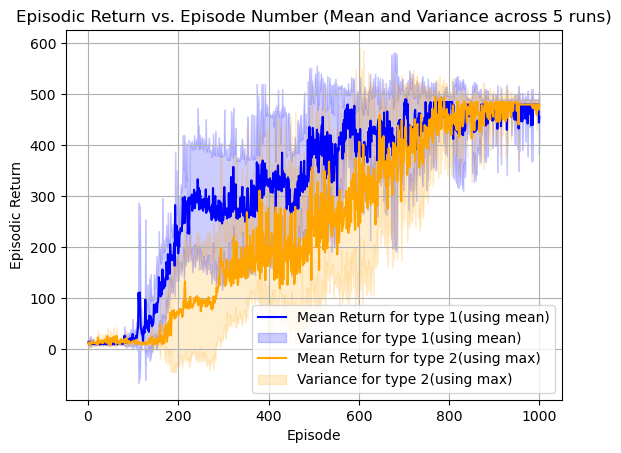

In [19]:

plt.plot(range(1, len(mean_rewards_cart_1) + 1), mean_rewards_cart_1, label='Mean Return for type 1(using mean)', color='blue')
plt.fill_between(range(1, len(mean_rewards_cart_1) + 1), mean_rewards_cart_1 - np.sqrt(variance_rewards_cart_1),
                 mean_rewards_cart_1 + np.sqrt(variance_rewards_cart_1), color='blue', alpha=0.2, label='Variance for type 1(using mean)')
plt.plot(range(1, len(mean_rewards_cart_2) + 1), mean_rewards_cart_2, label='Mean Return for type 2(using max)', color='orange')
plt.fill_between(range(1, len(mean_rewards_cart_2) + 1), mean_rewards_cart_2 - np.sqrt(variance_rewards_cart_2),
                 mean_rewards_cart_2 + np.sqrt(variance_rewards_cart_2), color='orange', alpha=0.2, label='Variance for type 2(using max)')

plt.xlabel('Episode')
plt.ylabel('Episodic Return')
plt.title('Episodic Return vs. Episode Number (Mean and Variance across 5 runs)')
plt.legend()
plt.grid(True)
plt.show()